In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation

In [18]:
import numpy as np
import tensorflow as tf

In [19]:
import gym

## simple cart pole

In [20]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [21]:
from PIL import Image, ImageDraw

def render_cart_pole(env, obs):
    # rendering for the cart pole environment (in case OpenAI gym can't do it)
    img_w = 600
    img_h = 400
    cart_w = img_w // 12
    cart_h = img_h // 15
    pole_len = img_h // 3.5
    pole_w = img_w // 80 + 1
    x_width = 2
    max_ang = 0.2
    bg_col = (255, 255, 255)
    cart_col = 0x000000 # Blue Green Red
    pole_col = 0x669acc # Blue Green Red

    pos, vel, ang, ang_vel = obs
    img = Image.new('RGB', (img_w, img_h), bg_col)
    draw = ImageDraw.Draw(img)
    cart_x = pos * img_w // x_width + img_w // x_width
    cart_y = img_h * 95 // 100
    top_pole_x = cart_x + pole_len * np.sin(ang)
    top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
    draw.line((0, cart_y, img_w, cart_y), fill=0)
    draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
    draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
    return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [6]:
env = gym.make("CartPole-v0")
obs = env.reset()
obs

[2017-02-28 11:40:20,862] Making new env: CartPole-v0


array([-0.04815011,  0.03531782,  0.04703576, -0.04335199])

<IPython.core.display.Javascript object>


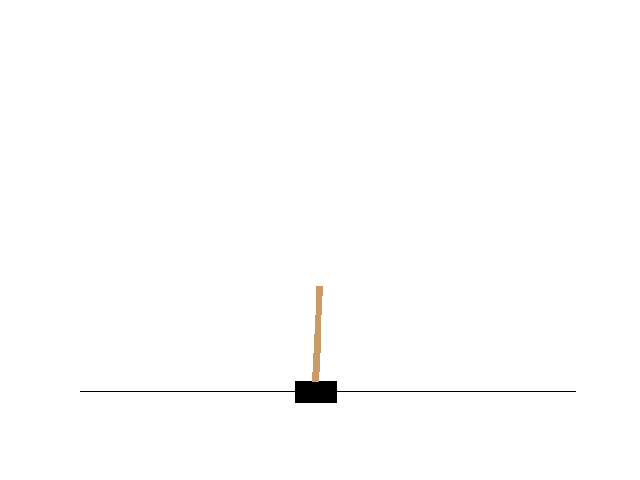

In [7]:
plot_cart_pole(env, obs)

In [8]:
env.action_space, env.observation_space

(Discrete(2), Box(4,))

## simple hard coded policy

In [9]:
frames = []
n_max_steps = 1000

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)
    
    position, velocity, angle, angular_velocity = obs
    action = 0 if angle < 0 else 1
    
    obs, reward, done, info = env.step(action)
    if done:
        frames.append(render_cart_pole(env, obs))
        break

<IPython.core.display.Javascript object>


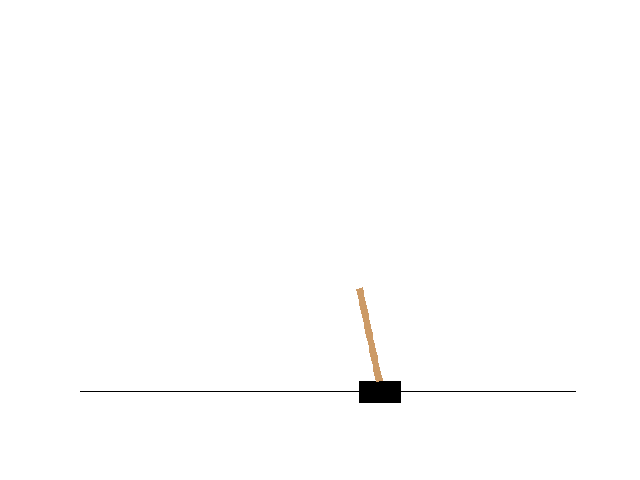

In [10]:
plot_animation(frames)

## policy with tensorflow

In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import variance_scaling_initializer

tf.reset_default_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

he_initializer = variance_scaling_initializer()

with tf.name_scope("cart-pole-nn"):
    with tf.contrib.framework.arg_scope([fully_connected],
                    weights_initializer=he_initializer):
        X = tf.placeholder(tf.float32, [None, n_inputs])
        h = fully_connected(X, n_hidden,
                            activation_fn=tf.nn.elu)
        logits = fully_connected(h, n_outputs, activation_fn=None)
        outputs = tf.nn.sigmoid(logits)
        p_left_right = tf.concat([outputs, 1-outputs], axis=1)
        action = tf.multinomial(tf.log(p_left_right), num_samples=1)

In [15]:
## play without learning

n_max_steps = 1000
frames = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(render_cart_pole(env, obs))
        action_val = sess.run(action, feed_dict={X: np.expand_dims(obs, 0)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break
env.close()

<IPython.core.display.Javascript object>


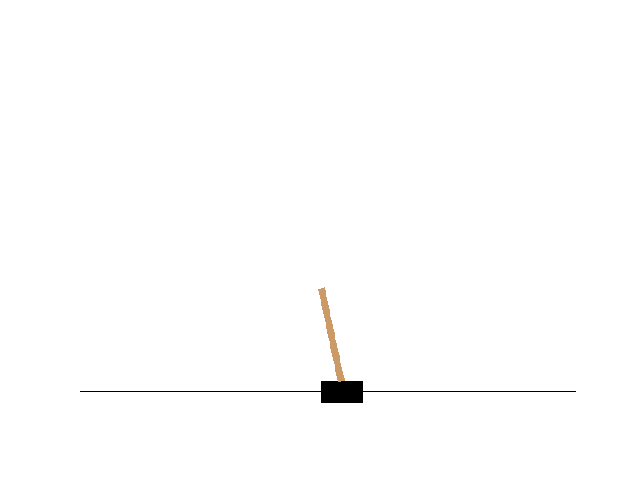

In [16]:
video = plot_animation(frames)
plt.show()

In [131]:
## use tensorflow to lean the simple policy

tf.reset_default_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

he_initializer = variance_scaling_initializer()

with tf.contrib.framework.arg_scope([fully_connected],
                    weights_initializer=he_initializer):
    X = tf.placeholder(tf.float32, [None, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_outputs])
    
    h = fully_connected(X, n_hidden, activation_fn=tf.nn.elu)
    logits = fully_connected(h, n_outputs, activation_fn=None)
    outputs = tf.nn.sigmoid(logits)
    p_left_right = tf.concat(values=[outputs, 1-outputs], axis=1)
    action = tf.multinomial(tf.log(p_left_right), num_samples=1)
    
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, axis=0)
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
saver = tf.train.Saver()

In [132]:
# train on 10 environments in parallel - take advantage of gpu training
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for it in range(n_iterations):
        targets = np.array([[1.] if ob[2] < 0 else [0.] for ob in observations])
        action_val, _, loss_val = sess.run([action, train_op, loss],
                                 feed_dict={X: np.array(observations), y: targets})
#         print(loss_val)
        for i, env in enumerate(envs):
            ob, reward, done, info = env.step(action_val[i][0])
            if done:
                ob = env.reset()
            observations[i] = ob
    saver.save(sess, "./naive_policy.chkpt")
    
for env in envs:
    env.close()

[2017-02-28 12:49:57,131] Making new env: CartPole-v0
[2017-02-28 12:49:57,140] Making new env: CartPole-v0
[2017-02-28 12:49:57,148] Making new env: CartPole-v0
[2017-02-28 12:49:57,160] Making new env: CartPole-v0
[2017-02-28 12:49:57,166] Making new env: CartPole-v0
[2017-02-28 12:49:57,172] Making new env: CartPole-v0
[2017-02-28 12:49:57,176] Making new env: CartPole-v0
[2017-02-28 12:49:57,179] Making new env: CartPole-v0
[2017-02-28 12:49:57,182] Making new env: CartPole-v0
[2017-02-28 12:49:57,184] Making new env: CartPole-v0


[2017-02-28 12:50:03,633] Making new env: CartPole-v0


<IPython.core.display.Javascript object>


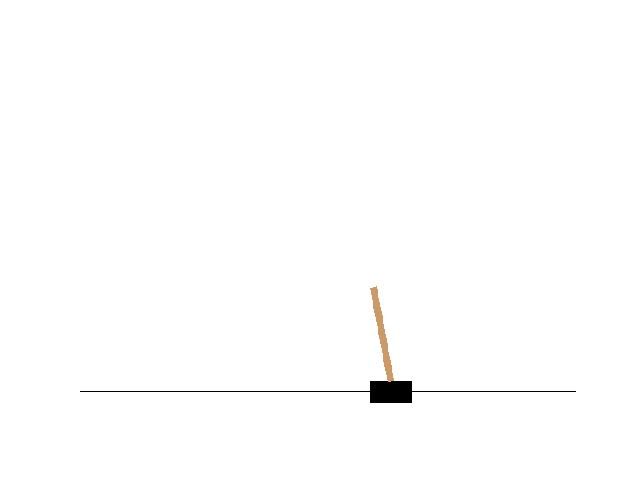

[]

In [133]:

n_max_steps = 1000
frames = []

env = gym.make("CartPole-v0")
obs = env.reset()
with tf.Session() as sess:
    saver.restore(sess, "./naive_policy.chkpt")
#     saver.restore(sess, "./my_policy_net_basic.ckpt")
    
    for step in range(n_max_steps):
        frames.append(render_cart_pole(env, obs))
        action_val = sess.run(action, feed_dict={X: np.expand_dims(obs, 0)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break
env.close()

video = plot_animation(frames)
plt.plot()

## policy gradients

In [76]:
import gym
import numpy as np
import tensorflow as tf

from tensorflow.contrib.framework import arg_scope
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import variance_scaling_initializer

tf.reset_default_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

he_initializer = variance_scaling_initializer()

with arg_scope([fully_connected], weights_initializer=he_initializer):
    X = tf.placeholder(tf.float32, [None, n_inputs])
    h = fully_connected(X, n_hidden, activation_fn=tf.nn.elu)
    logits = fully_connected(h, n_outputs, activation_fn=None)
    p_left = tf.nn.sigmoid(logits)
    p_left_right = tf.concat(values=[p_left, 1.-p_left], axis=1)
    action = tf.multinomial(tf.log(p_left_right), num_samples=1)
    
# collect gradients
y = 1. - tf.to_float(action)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(0.01)
gradients, variables = zip(*optimizer.compute_gradients(loss))

# create gradient placeholder and variable based on gradients
# so that later twisted value can flow in
gradient_placeholders = [tf.placeholder(tf.float32, g.get_shape()) 
                         for g in gradients]
train_op = optimizer.apply_gradients(list(zip(gradient_placeholders, variables)))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

print([v.name for v in variables])

['fully_connected/weights:0', 'fully_connected/biases:0', 'fully_connected_1/weights:0', 'fully_connected_1/biases:0']


In [77]:
## helper function for discount and normalized rewards
def discount_rewards(rewards, discount_rate):
    accum_reward = 0
    discounted_rewards = []
    for reward in reversed(rewards):
        accum_reward = reward + discount_rate * accum_reward
        discounted_rewards.append(accum_reward)
    return np.array(discounted_rewards[::-1])

def discount_and_normalize_rewards(all_rewards, discount_rate):
    discounted_rewards = [discount_rewards(reward, discount_rate) 
                        for reward in all_rewards]
    flat_rewards = np.concatenate(discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [ (rewards-reward_mean) / reward_std for rewards in discounted_rewards]

In [78]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [79]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([ 1.26665318,  1.0727777 ])]

In [80]:
## train with policy gradient

env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 200
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    # update gradient every iteration
    # within each iteration, collect rewards from n_games_per_update games
    # and update gradient based on them
    for iteration in range(n_iterations):
        print("\rIteration: %i" % iteration, end=" ")
        # need to collect all rewards and all gradients
        # for each step in each game
        all_rewards = [] # indexed by (game, step)
        all_gradients = [] # indexed by (game, step, variable)
        for game in range(n_games_per_update):
            ob = env.reset()
            thisgame_rewards = []
            thisgame_gradients = []
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients],
                                                     feed_dict={X: np.expand_dims(ob, axis=0)})
                ob, reward, done, info = env.step(action_val[0][0])
                thisgame_rewards.append(reward)
                thisgame_gradients.append(gradients_val)
                if done:
                    break
        all_rewards.append(thisgame_rewards)
        all_gradients.append(thisgame_gradients)
        # compute mean gradient
        all_rewards = discount_and_normalize_rewards(all_rewards,
                                                     discount_rate=discount_rate)
        feed_dict = {}
        # take mean on game, step for each variable, weighted by reward
        for v, gplaceholder in enumerate(gradient_placeholders):
            mean_gradient = np.mean([reward * all_gradients[g][s][v] 
                                     for g, game_rewards in enumerate(all_rewards)
                                     for s, reward in enumerate(game_rewards)], axis=0)
            feed_dict[gplaceholder] = mean_gradient
        sess.run(train_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
#             loss_val = sess.run([loss], feed_dict={X: np.expand_dims(ob, axis=0)})
#             print(loss_val, end="")
            saver.save(sess, "./pg.ckpt")

env.close()

[2017-02-28 17:47:15,461] Making new env: CartPole-v0


Iteration: 199 

[2017-02-28 17:53:55,622] Making new env: CartPole-v0


<IPython.core.display.Javascript object>


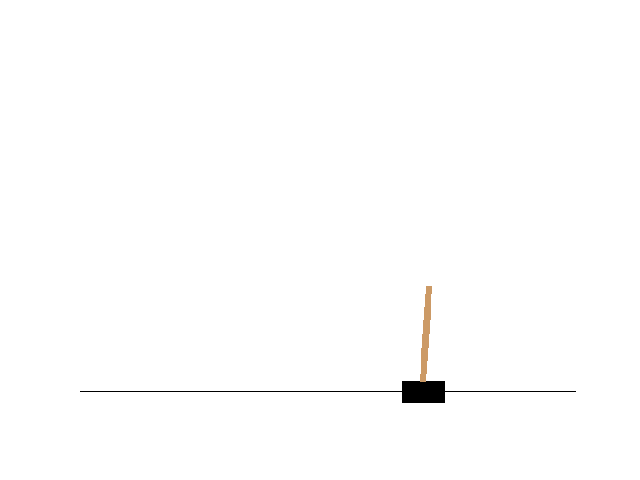

[]

In [84]:

n_max_steps = 1000
frames = []

env = gym.make("CartPole-v0")
obs = env.reset()
with tf.Session() as sess:
    saver.restore(sess, "./pg.ckpt")
#     saver.restore(sess, "./my_policy_net_pg.ckpt")
    
    for step in range(n_max_steps):
        frames.append(render_cart_pole(env, obs))
        action_val = sess.run(action, feed_dict={X: np.expand_dims(obs, 0)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break
env.close()

video = plot_animation(frames)
plt.plot()